## <center>Ensemble Learning with AdaBoost Regression</center>

**Name: Elise Rattigan**<br>
**Last modified:** August 2021<br>

This project is adapted from one of the assignments in my Machine Learning unit at university, for which I received a mark of 100%.

The purpose of this project was to use ensemble learning on the **Abalone dataset** from *UCI Machine Learning*, to predict the number of Rings of a given instance.

In this notebook, I will be using an AdaBoost Regressor with four base SVR estimators (with RBF kernel). I will be using `GridSearch` cross-validation to find the best combination of hyperparameters for both the ensemble and the base estimators, and then fitting the model. I will evaluate the ensemble's performance by calculting the mean absolute error (MAE) and obtaining the raw prediction errors.

In [1]:
# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

# Visualisations
from pandas.plotting import scatter_matrix

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error

## 1. Data Visualisation and Cleaning

The first step is to read in the data and output a pandas DataFrame. For this dataset, headers need to be hard-coded, as they are not included in the data file.

In [2]:
# List of column headers
header_list = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

# Specify directory where data is located
data_dir = os.path.join('data', 'abalone.data')

# Import data and assign column headers
abalone = pd.read_csv(data_dir, sep=',', names=header_list)

# Inspect first 5 lines of dataframe
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Overview of the dataframe
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


The above output shows that, as expected from the description of the dataset, there are 4177 observations and 9 attributes. The target attribute is `Rings` and the rest are predictor features.  There are no missing values. The `Sex` attribute is an `object`, a nominal-type feature with three possible values.  The rest of the attributes are numerical.

We can look at the correlations between pairs of features by using a scatter matrix, shown below.

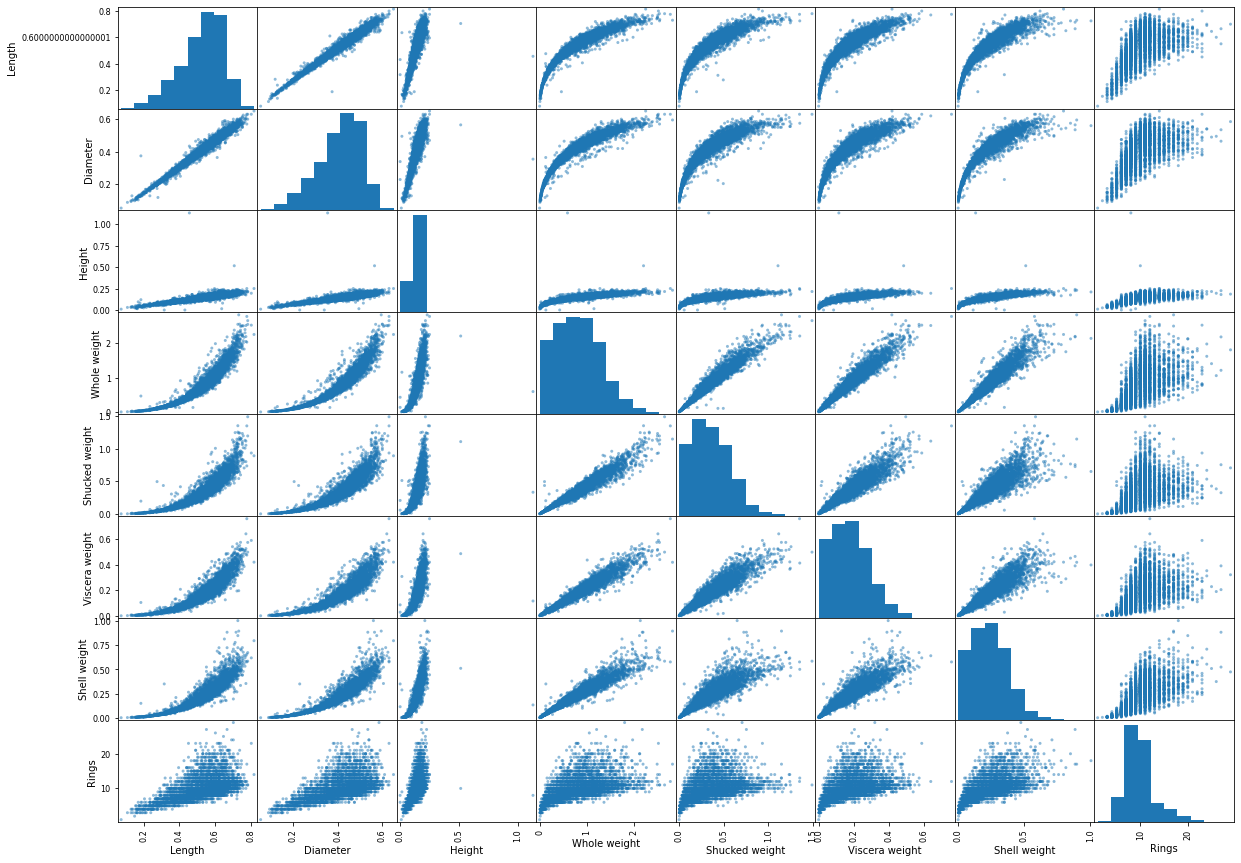

In [4]:
# Plot scatter matrix without 'Sex' variable
scatter_matrix(abalone[1:], figsize=(20, 15));

The above scatter matrix shows that Diameter and Length are highly correlated, as are Diameter and Height, and Length and Height. This is expected, as mathematically, these features are related. Height appears to be the feature most correlated with Rings, so I will keep this one. Diameter and Length are very similar, but looking at the statistics in the data description, Diameter does seem to have a greater spread, so may be a more useful predictor. Therefore, I will remove Length.

The four weight features are also highly correlated with each other, in particular, Whole weight and Shucked weight. It appears from the data description that Whole weight is a combination of the other three weights, so I should be able to remove Whole weight without losing too much information.

In [5]:
# Remove Length and Whole weight attributes
abalone = abalone.drop(['Length', 'Whole weight'], axis=1)

# Check dataframe
abalone.head()

,Sex,Diameter,Height,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.365,0.095,0.2245,0.1010,0.150,15
1,M,0.265,0.090,0.0995,0.0485,0.070,7
2,F,0.420,0.135,0.2565,0.1415,0.210,9
3,M,0.365,0.125,0.2155,0.1140,0.155,10
4,I,0.255,0.080,0.0895,0.0395,0.055,7


For the next data cleaning step, I need to convert the `Sex` variable from nominal to numerical. I can do this using one-hot encoding.

In [6]:
# First relabel M and F to A (for adult)
abalone['Sex'].replace({'M': 'A', 'F': 'A'}, inplace=True)

# Check dataframe
abalone.head()

,Sex,Diameter,Height,Shucked weight,Viscera weight,Shell weight,Rings
0,A,0.365,0.095,0.2245,0.1010,0.150,15
1,A,0.265,0.090,0.0995,0.0485,0.070,7
2,A,0.420,0.135,0.2565,0.1415,0.210,9
3,A,0.365,0.125,0.2155,0.1140,0.155,10
4,I,0.255,0.080,0.0895,0.0395,0.055,7


In [7]:
# Extract Sex column
sex_col = abalone[['Sex']]

# Create instance of encoder
encoder = OneHotEncoder()

# Transform the column data
sex_col_1hot = encoder.fit_transform(sex_col)
sex_col_1hot

<4177x2 sparse matrix of type '<class 'numpy.float64'>'
	with 4177 stored elements in Compressed Sparse Row format>

The output of the one-hot encoder transformation is a sparse matrix, which only stores the location of the non-zero elements in order to save space. We can add this data back into the original DataFrame by first converting it to a NumPy array, then turning it into a new DataFrame, and finally appending that DataFrame back onto the abalone DataFrame. Doing it this way preserves the formatting and column names of the original dataframe, and just adds the new one-hot encoded columns onto the end.

In [8]:
# Get list of encoder's categories
encoder.categories_

[array(['A', 'I'], dtype=object)]

In [9]:
# Convert sparse matrix to NumPy array
sex_array = sex_col_1hot.toarray()

# Create temp dataframe
sex_temp = pd.DataFrame(data=sex_array, columns=['Adult', 'Infant'])
sex_temp.head()

,Adult,Infant
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [10]:
# Merge temp dataframe onto abalone dataframe
abalone = pd.merge(abalone, sex_temp, left_index=True, right_index=True)

In [11]:
# Check dataframe
abalone.head()

,Sex,Diameter,Height,Shucked weight,Viscera weight,Shell weight,Rings,Adult,Infant
0,A,0.365,0.095,0.2245,0.1010,0.150,15,1.0,0.0
1,A,0.265,0.090,0.0995,0.0485,0.070,7,1.0,0.0
2,A,0.420,0.135,0.2565,0.1415,0.210,9,1.0,0.0
3,A,0.365,0.125,0.2155,0.1140,0.155,10,1.0,0.0
4,I,0.255,0.080,0.0895,0.0395,0.055,7,0.0,1.0


I will now run some checks on the DataFrame to check that the merge was carried out correctly. I will check to make sure that no rows with `Sex=A` have a 1.0 in the `Infant` column, and that no rows with `Sex=I` have a 1.0 in the `Adult` column.  I will also check for any missing values.

In [12]:
# Check no adults with 1 in infant column
abalone.loc[(abalone['Sex'] == 'A') & (abalone['Infant'] == 1.0)]

,Sex,Diameter,Height,Shucked weight,Viscera weight,Shell weight,Rings,Adult,Infant


In [13]:
# Check no infants with 1 in adult column
abalone.loc[(abalone['Sex'] == 'I') & (abalone['Adult'] == 1.0)]

,Sex,Diameter,Height,Shucked weight,Viscera weight,Shell weight,Rings,Adult,Infant


In [14]:
# Check whether any missing values
abalone.isna().any()

Sex               False
Diameter          False
Height            False
Shucked weight    False
Viscera weight    False
Shell weight      False
Rings             False
Adult             False
Infant            False
dtype: bool

In [15]:
# Drop Sex column from DataFrame
abalone = abalone.drop('Sex', axis=1)

In [16]:
# Overview of dataframe
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Diameter        4177 non-null   float64
 1   Height          4177 non-null   float64
 2   Shucked weight  4177 non-null   float64
 3   Viscera weight  4177 non-null   float64
 4   Shell weight    4177 non-null   float64
 5   Rings           4177 non-null   int64  
 6   Adult           4177 non-null   float64
 7   Infant          4177 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 261.2 KB


Viewing the overview of the data again, we can see there are still 4177 observations, but now 8 attributes. Two of these are the new dummy attributes that were created with one-hot encoding and replaced the original 'Sex' attribute.

## 2. AdaBoost Regressor

With the data cleaning and checks complete, I can now prepare the data for the AdaBoost regressor. I will use the `train_test_split` function from Scikit-Learn to randomly split the data into a training set and a test set, using an 85/15 split.

First, I will separate the target variable from the predictors using the function below.

In [17]:
# Function to prepare data
def prepare_data(df, target): 
    # Separate target variable from predictors
    X = df.drop(target, axis=1)
    y = df[target].values
    return X, y

In [18]:
# Apply function and assign to variables
X, y = prepare_data(abalone, 'Rings')

In [19]:
# Random seed for reproducibility
np.random.seed(100)

X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(X, y, test_size = 0.15) # 85/15 split

In [20]:
print('There are {} instances in the training set.'.format(len(y_train_ab)))

There are 3550 instances in the training set.


In [21]:
print('There are {} instances in the test set.'.format(len(y_test_ab)))

There are 627 instances in the test set.


I will now train an AdaBoost regressor on the abalone training set, using a Support Vector regressor (from the Scikit-Learn `SVR` class) with an RBF kernel as the base estimator. As SVR is a reasonably good estimator, I will keep the number of estimators low (4 or 5 estimators) to reduce training time and reduce the risk of overfitting.

Support Vector regressors **are** sensitive to feature scaling, so I will first use Scikit-Learn's `StandardScaler` class on the training set to transform the numerical features to have a mean of 0 and unit standard deviation. This operation should optimise the performance of the base SVR estimators.

As the `Adult` and `Infant` columns are binary values, it makes no sense to scale these, as they are either 1 or 0. So I will use the `ColumnTransformer` class from Scikit-Learn to only scale the remaining columns, which are float values.

In [22]:
# Use ColumnTransformer to transform only numerical (float) columns
ct = ColumnTransformer([
        ('scaler', StandardScaler(), ["Diameter", "Height", "Shucked weight", "Viscera weight", "Shell weight"])
    ], remainder='passthrough')

# Transform the training data
X_train_scaled = ct.fit_transform(X_train_ab)

In [23]:
# View the scaled training data for first instance
X_train_scaled[0]

array([-0.73801096,  0.00688392, -0.8836503 , -0.95437907, -0.63915243,
        1.        ,  0.        ])

In [24]:
# Transform the test data with same transformation
X_test_scaled = ct.transform(X_test_ab)

Next, I will use `GridSearchCV` with 3-fold cross-validation to find optimal hyperparameters for the base estimator, and the optimal number of estimators for the ensemble.  I will investigate the following hyperparameters for the base SVR:

* `C`, which is the regularisation parameter. A smaller value of C means more regularisation
* `gamma`, which is the parameter for RBF and poly kernels. It controls the range of influence of each instance. A small gamma means the instances have a larger range of influence, leading to a smoother decision boundary.

For the AdaBoost ensemble, I will investigate whether 4 or 5 base estimators is better. I will also investigate values for `learning_rate`, which specifies the contribution of each regressor to the ensemble (i.e. a lower learning rate means each regressor has less weight). There is a trade-off between `learning_rate` and `n_estimators` - fewer estimators usually requires a higher learning rate, and vice versa.

I have commented out the below grid search code as it takes a long time to run. You can uncomment the code if you wish to run it again.

In [25]:
# Create grid of parameters to search
# ada_params = [{'base_estimator__kernel': ['rbf'], 
#                'base_estimator__gamma': [0.01, 0.1, 'scale'], 
#                'base_estimator__C': [100, 500, 1000], 
#                'n_estimators': [4, 5],
#                'learning_rate': [0.5, 0.7, 1]}]

In [26]:
# Create AdaBoost instance with SVR base estimator
# ada = AdaBoostRegressor(base_estimator = SVR())

# Run GridSearchCV with grid of parameters, 3-fold cross-validation
# grid_search = GridSearchCV(ada, ada_params, cv=3, scoring='neg_mean_absolute_error')

# Fit to training data
# grid_search.fit(X_train_scaled, y_train_ab)

In [27]:
# Get the best combination of parameters
# grid_search.best_params_

When I ran the grid search code, the best hyperparameters for the base estimators were `C` = 500, `gamma` = 0.01, and the best hyperparameters for the AdaBoost regressor were a learning rate of 0.7, and 4 base estimators.

I will now fit an AdaBoost regressor on the training data using these hyperparameters.

In [28]:
# Train AdaBoost regressor on training set using the best parameters from original grid search
ada = AdaBoostRegressor(
    SVR(kernel='rbf', gamma=0.01, C=500), learning_rate=0.7, n_estimators=4)
ada_reg = ada.fit(X_train_scaled, y_train_ab)

Now that I have a fitted model, I can use it to make predictions, and evaluate the accuracy of those predictions by calculating the mean absolute errors.

I will calculate the mean absolute error for all of the intermediate models in the ensemble, as well as the final model.  This can be done using the `staged_predict` method of the fitted AdaBoost regressor.

The code below puts this process into a function so that it can be used to make predictions on both the training and test sets. It uses a loop to make predictions using each of the four base estimators, calculates the mean absolute error of each, and adds it to a list, so that we end up with four values of mean absolute error, one for each estimator.

In the function, I also cast the values of the predictions as integers, rounded to the nearest whole number, as `Ring` must be an integer.

In [29]:
# Function takes in data (X_train or X_test) and labels (y_train or y_test)
def get_ensemble_mae(input_data, labels):
    mae_list = []
    
    # For each base estimator, make predictions, round predictions to nearest integer and get MAE
    for pred in ada_reg.staged_predict(input_data):
        pred = np.round(pred).astype(int)
        mae = mean_absolute_error(labels, pred)
        mae_list.append(round(mae, 4))
    
    # Return list of MAE scores
    return mae_list

In [30]:
# Apply function to training set
mae_train = get_ensemble_mae(X_train_scaled, y_train_ab)

In [31]:
print('The mean absolute errors (MAE) for the four base estimators on the training set are: {}'.format(mae_train))

The mean absolute errors (MAE) for the four base estimators on the training set are: [1.44, 1.4515, 1.4363, 1.4411]


In [32]:
# Apply function to test set
mae_test = get_ensemble_mae(X_test_scaled, y_test_ab)

In [33]:
print('The mean absolute errors (MAE) for the four base estimators on the test set are: {}'.format(mae_test))

The mean absolute errors (MAE) for the four base estimators on the test set are: [1.4211, 1.4402, 1.4434, 1.4354]


I ran this code a few times when creating this notebook, and found that the MAE scores varied each time it was run, so results may differ if the notebook is run again. This is because the SVR base estimators do not allow a `random_state` parameter to be set. However, in general, based on the output I have seen, it appears that the model actually performed better on the test set than it did on the training set, which is excellent, as it means the model can generalise well to new data.

From the output I have seen, the MAE scores were around 1.44 on the training set and around 1.43 on the test set. They tended to increase for the second intermediate model, but then reduce again so that the final model had the lowest or second lowest MAE. However, this did vary a little each time I ran the code.

We can visualise these scores on a graph, to compare the performance of the estimators on the training set with that on the test set. The below graph shows the MAE score for each base estimator (1 to 3 being the intermediate models and 4 being the final model) on both the training and test sets.

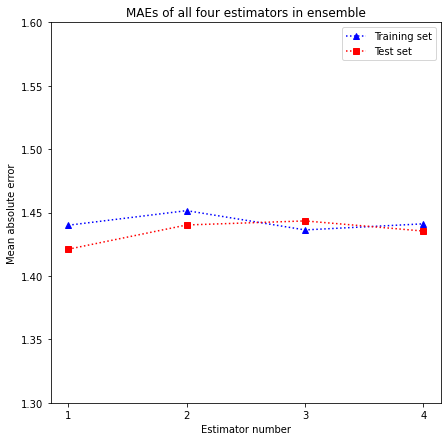

In [34]:
# Create the axes
fig,ax = plt.subplots(figsize=(7, 7))

# Labels for X-axis
n_estimator = [1, 2, 3, 4]

# Plot the data
ax.plot(n_estimator, mae_train, 'b^', linestyle='dotted')
ax.plot(n_estimator, mae_test, 'rs', linestyle='dotted')

# Add titles and axis labels, set axis ticks and lims
ax.set(title="MAEs of all four estimators in ensemble",
       xlabel="Estimator number",
       ylabel="Mean absolute error",
       xticks=n_estimator,
       ylim=[1.3, 1.6])

# Add legend
ax.legend(['Training set', 'Test set']);

Again, the results in the graph may vary if the code is run again. In general, the first two intermediate estimators performed slightly better on the training set than they did on the test set. The scores then converge for the final two estimators, so that MAE is very similar, even ending up slightly lower on the test set than on the training set. In general, the final estimator has the lowest MAE and performs very similarly on both training and test sets. This demonstrates how Adaptive Boosting can combine several weak learners to create a stronger learner.

We can also generate the prediction results, on both the training and test sets, of the final model, and plot these against the true values to evaluate the prediction results. The below function to generate predictions accepts the fitted model, the data that was input into the model and the true labels, and outputs the predictions.

In [35]:
# Function to generate predictions
# Takes in model, data (train or test) and labels (train or test)
def get_predictions(model, input_data, labels):
    # Make predictions and round to nearest integer
    pred = np.round(model.predict(input_data).astype(int))
    return pred

In [36]:
# Generate predictions for training and test sets
pred_train_ab = get_predictions(ada_reg, X_train_scaled, y_train_ab)
pred_test_ab = get_predictions(ada_reg, X_test_scaled, y_test_ab)

Below, I have created another function to plot subplots of the predictions against the true values.

The function accepts the true values and predicted values for both the training and test data, as well as numbers for the xlim and ylim, so the graphs are shown on the same scale.

In [37]:
# Function to generate subplots of predictions v truth
# Takes in training labels, test labels, predictions on training and test sets, and some graph size specs

def pred_subplots(train_labels, test_labels, pred_train, pred_test, xlim, ylim, figsize):
    
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Plot the data
    ax1.plot(train_labels, pred_train, 'b^', alpha=0.2)
    ax2.plot(test_labels, pred_test, 'rs', alpha=0.2)
    
    # Add line for true values   
    ax1.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'k--', lw=2)
    ax2.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2)

    # Set the subplot titles
    ax1.set(title='Prediction results on training set')
    ax2.set(title='Prediction results on test set')

    for ax in fig.get_axes():
        ax.set(xlabel='True values',
           ylabel='Predicted values',
           xlim=xlim,
           ylim=ylim);
        
    return

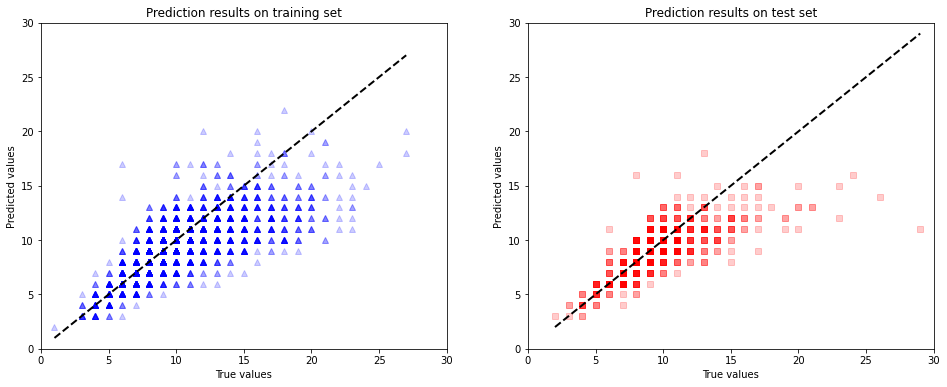

In [38]:
# Apply function to labels and predictions
pred_subplots(y_train_ab, y_test_ab, pred_train_ab, pred_test_ab, xlim=[0, 30], ylim=[0, 30], figsize=(16, 6))

In the graphs above, I have set the `alpha` level to demonstrate the frequency of the values: darker triangles or squares indicate more values at that point.

Looking at these plots, it appears that the model did quite a good job at predicting on the test set. Most of the points are quite close to the central black line, which indicates where predicted values = true values. There are obviously more instances in the training set than the test set, which makes comparison a bit difficult, but the spread of points on the test set does appear to be closer to the black line. I will go into more detail on this comparison in the section at the end of this notebook.

We can also look at the **raw prediction errors** of the final model by visualising the distribution of these errors as a histogram. To get the raw prediction errors, I will simply take the difference (residual) of each true value and predicted value. I will then plot these residuals as a histogram.

I have created two functions below. The first one simply gets the residuals, as explained. The second function plots the residuals as histograms in two subplots, by calling the first function within it.  It accepts the true values and predicted values for both the training and test data, as well as a minimum and maximum value, which will determine the limits of the x-axis and the histogram bins, and an interval value to control the bin widths.

In [39]:
# Function to get residuals
def get_residuals(labels, pred):
    return pred - labels

In [40]:
# Function to plot raw prediction error histograms
# Takes in training labels, test labels, predictions on training and test sets, and some graph size specs

def plot_raw_errors(train_labels, test_labels, pred_train, pred_test, xmin, xmax, interval, figsize):
    
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Get residuals using function
    train_residuals = get_residuals(train_labels, pred_train)
    test_residuals = get_residuals(test_labels, pred_test)
    
    # Plot the data
    ax1.hist(train_residuals, bins=np.arange(xmin, xmax, interval) - (interval/2), edgecolor="black")
    ax2.hist(test_residuals, bins=np.arange(xmin, xmax, interval) - (interval/2), edgecolor="black")
    
    # Set the subplot titles
    ax1.set(title='Raw prediction errors on training set')
    ax2.set(title='Raw prediction errors on test set')
    
    for ax in fig.get_axes():
        ax.set(xlabel="Raw prediction error (predicted - truth)",
               ylabel="Frequency",
               xlim=[xmin, xmax])        
    
    return

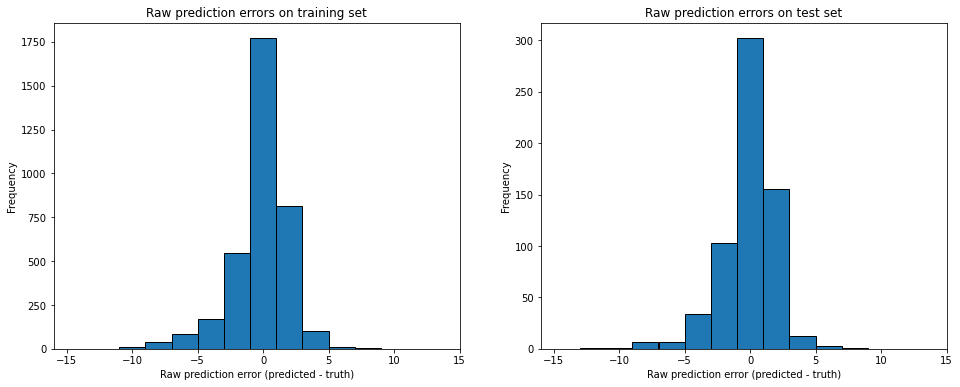

In [41]:
# Apply function to generate histograms
plot_raw_errors(y_train_ab, y_test_ab, pred_train_ab, pred_test_ab, xmin=-16, xmax=15, interval=2, figsize=(16, 6))

The above histograms show the frequency distributions of the raw errors in predictions, on both the training set and the test set. The raw errors range from about -12 to +9, but the majority of the errors were from about -3 to +3.

Comparing the histograms, we can see that there is a very similar spread of raw prediction errors between the two. I will go into more detail on this comparison in the next section.

## 3. Comparison and Summary 

For ease of reference when reading this comparison, I will show the two plots again below, so there is no need to keep scrolling back up the page to look at the graphs:

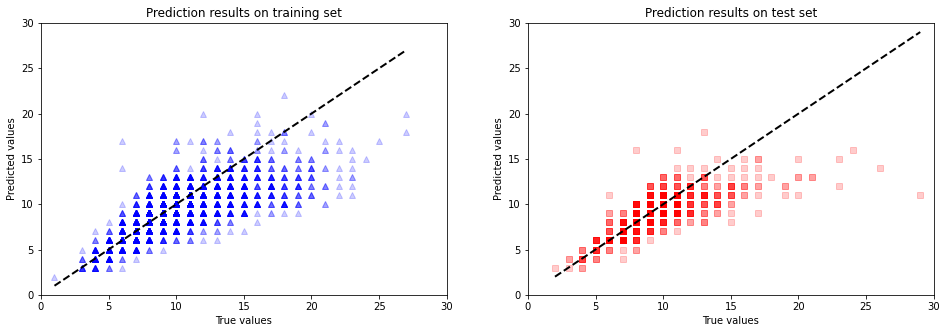

In [42]:
# Show predictions scatterplot again
pred_subplots(y_train_ab, y_test_ab, pred_train_ab, pred_test_ab, xlim=[0, 30], ylim=[0, 30], figsize=(16, 5))

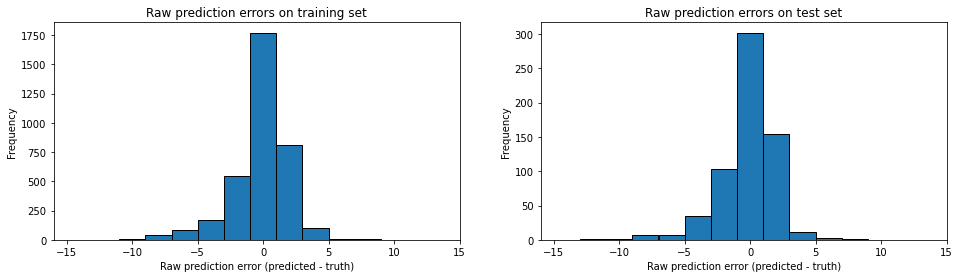

In [43]:
# Show histograms again
plot_raw_errors(y_train_ab, y_test_ab, pred_train_ab, pred_test_ab, xmin=-16, xmax=15, interval=2, figsize=(16, 4))

Looking at the scatterplots, we can see that the AdaBoost Regressor performed very similarly on both the training set and test set, meaning it generalises well to new instances and is therefore quite a good predictor. As I mentioned previously, it does seem as though the test set points are less spread out and are closer to the central black line. On both scatterplots, the points tend to spread more below the black line, suggesting that the ensemble tends to predict lower values than the truth, i.e. it predicts 10 when the truth is 20. This is more pronounced on the test set, which has a few values even further to the right of the x-axis than the training set.

This is supported by the histograms, which show that the test set has proportionally more errors from -10 to around -13 than the training set, meaning it has made relatively more predictions lower than the truth. However, there are very few instances like this, and most are within the -3 to +3 raw error range. It is good to see that on both histograms, the largest bin is for an error of 0, meaning the correct value was predicted. Again, this suggests that the predictor is quite strong and performs well on both the training instances and new unseen instances.